Bluequbit Q8 attempt
same method as for Q7

In [1]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile

import re
import networkx as nx

path = "C:/Users/elena/OneDrive/IQuhack/P8_bold_peak.qasm"

qc = QuantumCircuit.from_qasm_file(path)
qasm_text = open(path).read()
qasm_file = path

In [2]:
#these compile functions are building a search tool to find the cz and u3 gates 
#in the qasm program. 
#essentially REGEX patterns for my qasm format in the file
CZ_RE = re.compile(r'^\s*cz\s+q\[(\d+)\],\s*q\[(\d+)\]\s*;\s*$')
U3_RE   = re.compile(r'^\s*u3\(([^)]+)\)\s+q\[(\d+)\]\s*;\s*$')
QREG_RE = re.compile(r'^\s*qreg\s+q\[(\d+)\]\s*;\s*$')

In [ ]:
#here we want to write our functions for the algo 
#the functions we need are 
# 1) def read_number_of_qubits(qasm_text)
# 2) def interactions_graph
# 3) extract clusters 
# 4) draw graph
# 5) extract QASM code for clusters separately 
# 6) simulate clusters separately and output bitstring w prob (using aer sampling)
# 7) recombine peaks

In [3]:
CZ_RE = re.compile(r'^\s*cz\s+q\[(\d+)\],\s*q\[(\d+)\]\s*;\s*$')
U3_RE   = re.compile(r'^\s*u3\(([^)]+)\)\s+q\[(\d+)\]\s*;\s*$')
QREG_RE = re.compile(r'^\s*qreg\s+q\[(\d+)\]\s*;\s*$')

#function that reads the number of qubits from the qasm file
def read_num_qubits(qasm_text: str) -> int:
    """Extract n from 'qreg q[n];'."""
    for line in qasm_text.splitlines():
        m = QREG_RE.match(line)
        if m:
            return int(m.group(1))
    raise ValueError("Couldn't find 'qreg q[...]' line")

#function that builds the interaction graph from the qasm file
def build_interaction_graph_for_this_file(qasm_text: str) -> nx.Graph:
    """
    Nodes: qubit indices.
    Edges: whenever we see 'cz q[i],q[j];'
    """
    n = read_num_qubits(qasm_text)
    G = nx.Graph() #builds empty graph
    G.add_nodes_from(range(n)) #adds all qubits as nodes 

    for line in qasm_text.splitlines():
        m = CZ_RE.match(line) #asks if the line matches the cz gate format. if so, then M obtains value. if not, then m is nothing
        if m:
            i, j = int(m.group(1)), int(m.group(2)) #extracts qubit numbers
            G.add_edge(i, j) #adds edge between qubits i and j
            
    return G

#function that extracts clusters from the interaction graph
def extract_clusters(G: nx.Graph):
    """
    Returns connected components sorted by size descending.
    Each component is a sorted list of qubit indices.
    """
    comps = list(nx.connected_components(G)) #creates a list of sets - each set is a connected component of the graph
    comps = [sorted(list(c)) for c in comps] #converts the above - each set into a numerically ascending sorted list 
    comps.sort(key=len, reverse=True) #sort those clusters/lists by descending size 
    return comps

In [6]:
import matplotlib.pyplot as plt

def draw_graph(G):
    plt.figure(figsize=(5, 5))
    
    # Layout algorithm: spreads nodes nicely
    pos = nx.spring_layout(G, seed=42)
    
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=400,
        font_size=8,
        node_color="lightblue",
        edge_color="gray"
    )
    
    plt.title("Qubit Interaction Graph (edges = CZ gates)")
    plt.show()


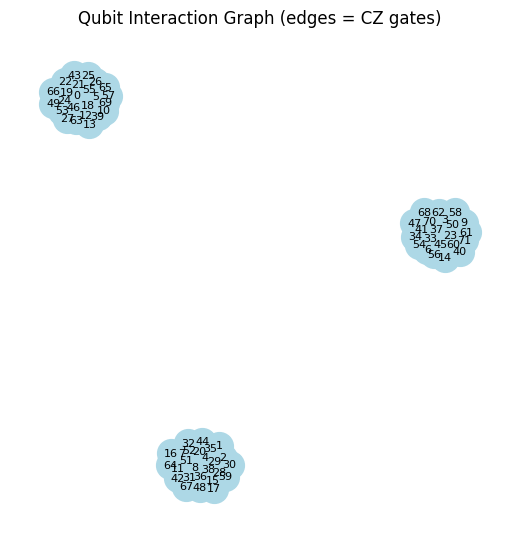

In [7]:
G = build_interaction_graph_for_this_file(qasm_text)
draw_graph(G)


In [9]:
clusters = extract_clusters(G)

print(f"Found {len(clusters)} clusters (connected components).")
for k, comp in enumerate(clusters, start=1):
    print(f"Cluster {k} (size {len(comp)}): {comp}")

compA = clusters[0]
compB = clusters[1]
compC = clusters[2]

Found 3 clusters (connected components).
Cluster 1 (size 26): [1, 2, 4, 7, 8, 11, 15, 16, 17, 20, 28, 29, 30, 31, 32, 35, 36, 38, 42, 44, 48, 51, 52, 59, 64, 67]
Cluster 2 (size 24): [0, 5, 10, 12, 13, 18, 19, 21, 22, 24, 25, 26, 27, 39, 43, 46, 49, 53, 55, 57, 63, 65, 66, 69]
Cluster 3 (size 22): [3, 6, 9, 14, 23, 33, 34, 37, 40, 41, 45, 47, 50, 54, 56, 58, 60, 61, 62, 68, 70, 71]


In [10]:
def extract_component_qasm(qasm_text: str, qubits: list[int]) -> str:
    """
    Build a new QASM string containing only gates that act entirely inside each cluster.
    Remap original qubit labels -> 0..k-1.
    Supports: u3, cz (matches file).
    """
    qset = set(qubits)
    remap = {q: i for i, q in enumerate(qubits)}
    out_lines = [
        "OPENQASM 2.0;",
        'include "qelib1.inc";',
        f"qreg q[{len(qubits)}];"
    ]

    for line in qasm_text.splitlines():
        line = line.strip()
        if not line:
            continue

        # Skip headers
        if line.startswith("OPENQASM") or line.startswith("include") or line.startswith("qreg"):
            continue

        mu = U3_RE.match(line)
        if mu:
            params = mu.group(1)          # "theta,phi,lambda" as text
            q = int(mu.group(2))
            if q in qset:
                out_lines.append(f"u3({params}) q[{remap[q]}];")
            continue

        mc = CZ_RE.match(line)
        if mc:
            i = int(mc.group(1))
            j = int(mc.group(2))
            if i in qset and j in qset:
                out_lines.append(f"cz q[{remap[i]}],q[{remap[j]}];")
            continue

    return "\n".join(out_lines) + "\n" # this returns a valid qasm string for the cluster

def peak_bitstring_by_sampling(qasm_str: str, shots=200000):
    qc = QuantumCircuit.from_qasm_str(qasm_str)

    # If there are no measurements in the QASM, add them
    if qc.num_clbits == 0:
        qc.measure_all()

    sim = AerSimulator()  # qasm sampling backend
    tqc = transpile(qc, sim, optimization_level=0) # transpiling means adapting the circuit to the backend
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts()

    peak = max(counts, key=counts.get)
    peak_prob_est = counts[peak] / shots
    return peak, peak_prob_est

def recombine_peaks(n_total: int, clusters: list[list[int]], peaks: list[str]) -> str:
    #n_total is number of qubits in og circuit, clusters = [compA, compB], peaks = [peakA, peakB]
    """
    Put each cluster's peak bits back into the original qubit ordering.
    Returns full-length bitstring indexed by q[0]..q[n_total-1].
    """
    bits = ["0"] * n_total
    for qubits, peak in zip(clusters, peaks): #pairs each cluster with its peak string
        if len(peak) != len(qubits):
            raise ValueError("Peak length doesn't match cluster size.")
        
        # reverse because counts are returned as c[k-1]...c[0]
        #NEW ADDITION!! 
        peak = peak[::-1]

        for local_i, orig_q in enumerate(qubits): #local index with the cluster and the corresponding original qubit label
            bits[orig_q] = peak[local_i]
        #essentially places each peak bit into its original qubit position    
    return "".join(bits) #turns the list of bits into a string 


In [ ]:
# Simulate each cluster
peaks = []
peak_probs = []
n_total = read_num_qubits(qasm_text)
for k, qubits in enumerate(clusters, start=1):
        sub_qasm = extract_component_qasm(qasm_text, qubits)
        #peak_str, peak_p = peak_bitstring_from_qasm_string(sub_qasm)
        peak_str, peak_p = peak_bitstring_by_sampling(sub_qasm, shots=300000)
        peaks.append(peak_str)
        peak_probs.append(peak_p)

        print(f"\nCluster {k} result:")
        print(f"  size: {len(qubits)}")
        print(f"  peak bitstring (local order 0..{len(qubits)-1}): {peak_str}")
        print(f"  peak probability: {peak_p:.6g}")

# Recombine into full answer
full_peak = recombine_peaks(n_total, clusters, peaks)

full_prob = 1.0 
for p in peak_probs: 
    full_prob *= p


print("\nRecombined full peak (q[0]..q[n-1]):")
print(full_peak)
print("\nEstimated full peak probability:")
print(full_prob)




Cluster 1 result:
  size: 26
  peak bitstring (local order 0..25): 10100001111011100100001001
  peak probability: 0.60124

Cluster 2 result:
  size: 24
  peak bitstring (local order 0..23): 111010111010011100011100
  peak probability: 0.60032

Cluster 3 result:
  size: 22
  peak bitstring (local order 0..21): 1011011000100101011001
  peak probability: 0.60139

Recombined full peak (q[0]..q[n-1]):
010100010010111001000011110001110011101110100011010001000111101001111101

Estimated full peak probability:
0.217063539671552
